<img src = "https://www.globalrealestateexperts.com/wp-content/uploads/2017/07/10_Hottest_Startups_Cropped-1078x516.jpg" width="700"> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>
<center><font size = 4>By Raheel Syed</font></center>

# Introduction

New York City is recognized worldwide as one the largest and ethnically diverse cities. It is described as "melting pot", home to a vastly diverse descrographic group of citizens and immigrants alike. With such a rich, diverse ethic population, there is the inevitable growth of diverse cultures, cuisines, languages, etc. 

The main goal of this project is the compare the geographic distribution of various cultural restaurants as an indication of cultural themes/dominance within NYC neighborhoods in order to highlight potential neighborhoods to open a new restaurant.

# Data  
For this project we will use the following data sources for our exploratory analysis:
<ul>
<li> New York City Neighborhood Data.
    <ul>
        <li>Source : https://cocl.us/new_york_dataset
        <li> Details : This json data set contains the neighborhood information including Boroughs, Neighborhoods, and geographic coordinates (latitude and longitude).
     </ul>  

<li> Restaurants within each neighborhood of New York City.
        <ul>
        <li>Source : Fousquare API
        <li> Details : By using this api we can retrieve all the restaurant venues within each neighborhood for analysis.
     </ul>

# Data Loading and Wrangling  
Let's first load all dependencies that will be needed for analysis.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Load New York City Data  
Get location coordinates for neighborhoods and boroughs in New York City.

In [2]:
def get_newyork_data():
    url='https://cocl.us/new_york_dataset'
    newyork_data=requests.get(url).json()
    # all data is present in features label in json
    neighborhoods_data=newyork_data['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    neighborhoods = pd.DataFrame(columns=column_names)
    
    for data in neighborhoods_data:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return neighborhoods

View the structure and size of the dataset loaded:

In [3]:
ny_data=get_newyork_data() #load NYC data from json file
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_data['Borough'].unique()),
        ny_data.shape[0]
    )
)
ny_data.head()

The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Determine the latitude and longitude coordinates of New York City to use as the center of a graph which will display New York Neighborhoods.

In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Display map of New York City with Neighborhood Markers

In [5]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Borough'], ny_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Explore and Segment Restaurent Venue Data using Foursquare API  
### Foursquare Restaurant Venue Category IDs: 
Afghan Restaurant = '503288ae91d4c4b30a586d67'  
African Restaurant = '4bf58dd8d48988d1c8941735'      
Burmese Restaurant = '56aa371be4b08b9a8d573568'  
Cambodian Restaurant = '52e81612bcbc57f1066b7a03'  
Chinese Restaurant = '4bf58dd8d48988d145941735'  
Filipino Restaurant = '4eb1bd1c3b7b55596b4a748f'  
Indonesian Restaurant = '4deefc054765f83613cdba6f'  
Japanese Restaurant = '4bf58dd8d48988d111941735'  
Korean Restaurant = '4bf58dd8d48988d113941735'  
Mongolian Restaurant = '4eb1d5724b900d56c88a45fe'  
Thai Restaurant = '4bf58dd8d48988d149941735'  
English Restaurant = '52e81612bcbc57f1066b7a05'  
Indian Restaurant = '4bf58dd8d48988d10f941735'  

### Foursquare Credentials

In [13]:
CLIENT_ID = 'M5RVHUFECMFIPNYREQQN4K5SFKTO0QNLVG5O5IEDVHJQYFUE' # your Foursquare ID
CLIENT_SECRET = 'HRIPJWCCZPNBZJ0OY3KIEZB4QXIX4410XBKW5B5FWGQH5DER' # your Foursquare Secret
VERSION = '20190515' # Foursquare API version

### Retrieve Restaurants by Neighborhood Using Foursquare API  
We can generate API url string for search query using below method. This will include list of pre-selected list of restaurant categories we will use for exploration.

In [14]:
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            limit
        )
    return url

endpoint = 'https://api.foursquare.com/v2/venues/search?'
categoryIds = ['503288ae91d4c4b30a586d67','4bf58dd8d48988d1c8941735','56aa371be4b08b9a8d573568','52e81612bcbc57f1066b7a03','4bf58dd8d48988d145941735','4eb1bd1c3b7b55596b4a748f','4deefc054765f83613cdba6f','4bf58dd8d48988d111941735','4bf58dd8d48988d113941735','4eb1d5724b900d56c88a45fe','4bf58dd8d48988d149941735','52e81612bcbc57f1066b7a05','4bf58dd8d48988d10f941735',]
categoryId = ','.join(categoryIds)
limit = 50
#print(createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, 100, categoryId, limit))

Below function will be used to invoke Foursquare API and return a dataframe of restaurant details found within each neighborhood's vicinity.

In [18]:
def getNearbyRestaurants(neighborhoods, latitudes, longitudes, radius=500):
    endpoint = 'https://api.foursquare.com/v2/venues/search?'
    venues_list = []   
    
    for hood_name, lat, lng in zip(neighborhoods, latitudes, longitudes):
        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        #print(url)
        #try:
        results = requests.get(url).json()['response']['venues']
        #print(results)
        #except KeyError:
        #    continue

        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            
            venues_list.append([(hood_name,
                                lat,
                                lng,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lng,
                               )])
    #if venues_list:
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue Name',
                             'Venue Category',
                             'Venue Latitude',
                             'Venue Longitude',
                            ]
    return nearby_venues

In [20]:
#prelim_rest_data = getNearbyRestaurants(ny_data['Neighborhood'][0:10],ny_data['Latitude'][0:10],ny_data['Longitude'][0:10])
#print(prelim_venue_data.shape)
#prelim_rest_data.head(10)
#df = pd.DataFrame(data = {'Neighborhood': ['Bronx', 'Field'], 'Latitude': [40.874294, 40.89470517661], 'Longitude': [-73.829939,-73.84720052054902]})
#prelim_rest_data = getNearbyRestaurants(df['Neighborhood'],df['Latitude'],df['Longitude'])
#prelim_rest_data.head()
restaurant_data = getNearbyRestaurants(ny_data['Neighborhood'],ny_data['Latitude'],ny_data['Longitude'])
restaurant_data.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Co-op City,40.874294,-73.829939,Chinese Buffet (All You Can Eat),Chinese Restaurant,40.869505,-73.827866
1,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,Chinese Restaurant,40.876603,-73.829710
2,Eastchester,40.887556,-73.827806,Xing Lung Chinese Restaurant,Chinese Restaurant,40.888785,-73.831226
3,Riverdale,40.890834,-73.912585,Cumin Indian Cuisine,Indian Restaurant,40.886459,-73.909816
4,Riverdale,40.890834,-73.912585,Golden Gate Chinese Restaurant,Chinese Restaurant,40.886398,-73.909683
5,Riverdale,40.890834,-73.912585,Aoyu Japanese Restaurant,Japanese Restaurant,40.886257,-73.909719
6,Riverdale,40.890834,-73.912585,Hunan Balcony,Chinese Restaurant,40.886039,-73.910030
7,Riverdale,40.890834,-73.912585,Palace of Japan,Japanese Restaurant,40.885841,-73.910064
8,Riverdale,40.890834,-73.912585,Planet Tokyo,Sushi Restaurant,40.886158,-73.909615
9,Riverdale,40.890834,-73.912585,Nam Thai,Thai Restaurant,40.886211,-73.909991


### Display Number of Restaurants Found for each Neighborhood

In [24]:
#restaurant_data.head()
restaurant_data[['Neighborhood','Venue Category']].groupby('Neighborhood').count().head()

,Venue Category
Neighborhood,
Allerton,4
Annadale,1
Arrochar,1
Arverne,2
Astoria,23


**Let's see how many unique restaurant types were curated for New York City**

In [40]:
print('There are {} uniques categories.'.format(len(restaurant_data['Venue Category'].unique())))
print('Empty rows returned from Foursquare search query: ', restaurant_data.isnull().values.any())

There are 95 uniques categories.
Empty rows returned from Foursquare search query:  False


### Analyze Results

In [42]:
# one hot encoding
restaurant_onehot = pd.get_dummies(restaurant_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
restaurant_onehot['Neighborhood'] = restaurant_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_onehot.head()
#restaurant_onehot.shape

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Belgian Restaurant,Bubble Tea Shop,Buffet,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Chinese Restaurant,Cocktail Bar,Coffee Shop,Cuban Restaurant,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,Grocery Store,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotpot Restaurant,Hunan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indonesian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Peruvian Restaurant,Poke Place,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,South Indian Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Street Food Gathering,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Riverdale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Riverdale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Remove entries not associated with Restaurants

In [43]:
restaurant_categories = ['Afghan Restaurant','African Restaurant','American Restaurant','Belgian Restaurant',
                         'Burmese Restaurant','Cambodian Restaurant','Cantonese Restaurant','Carribbean Restaurant',
                         'Chinese Restaurant','Cuban Restaurant','Ethiopian Restaurant','Filipino Restaurant',
                         'French Restaurant','Hawaiian Restaurant','Indian Chinese Restaurant','Indonesian Restaurant',
                         'Japanese Restaurant','Korean Restaurant','Mediterranean Restaurant','Mexican Restaurant',
                         'Mongolian Restaurant','Thai Restaurant','Taiwanese Restaurant','English Restaurant',
                         'Vietnamese Restaurant','Indian Restaurant']
ny_restaurant_venues = restaurant_data[restaurant_data['Venue Category'].isin(restaurant_categories)]
delta = restaurant_data.shape[0] - ny_restaurant_venues.shape[0]
print(f'{delta} entries were removed based on "Venue Category" not being related to restaurants.')
print(ny_restaurant_venues['Venue Category'].unique())
ny_restaurant_venues.head(5)

866 entries were removed based on "Venue Category" not being related to restaurants.
['Chinese Restaurant' 'Indian Restaurant' 'Japanese Restaurant'
 'Thai Restaurant' 'Korean Restaurant' 'Afghan Restaurant'
 'African Restaurant' 'Indian Chinese Restaurant' 'Cantonese Restaurant'
 'Mexican Restaurant' 'Ethiopian Restaurant' 'Filipino Restaurant'
 'Hawaiian Restaurant' 'Taiwanese Restaurant' 'English Restaurant'
 'French Restaurant' 'Cuban Restaurant' 'American Restaurant'
 'Indonesian Restaurant' 'Vietnamese Restaurant' 'Cambodian Restaurant'
 'Belgian Restaurant' 'Mongolian Restaurant' 'Mediterranean Restaurant']


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Co-op City,40.874294,-73.829939,Chinese Buffet (All You Can Eat),Chinese Restaurant,40.869505,-73.827866
1,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,Chinese Restaurant,40.876603,-73.829710
2,Eastchester,40.887556,-73.827806,Xing Lung Chinese Restaurant,Chinese Restaurant,40.888785,-73.831226
3,Riverdale,40.890834,-73.912585,Cumin Indian Cuisine,Indian Restaurant,40.886459,-73.909816
4,Riverdale,40.890834,-73.912585,Golden Gate Chinese Restaurant,Chinese Restaurant,40.886398,-73.909683


### One-Hot Encoding  
Apply one-hot encoding to venue category column to convert categorical values to numeric. This preprocessing step is needed in order to apply k-means clustering model on this dataset.

In [44]:
# one hot encoding
restaurant_onehot = pd.get_dummies(ny_restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
restaurant_onehot['Neighborhood'] = ny_restaurant_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_onehot.head()
#restaurant_onehot.shape

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Belgian Restaurant,Cambodian Restaurant,Cantonese Restaurant,Chinese Restaurant,Cuban Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant,French Restaurant,Hawaiian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Mongolian Restaurant,Taiwanese Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Co-op City,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Co-op City,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Eastchester,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Riverdale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Riverdale,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Get average occurrence frequency for each restaurant category by neighborhood

In [45]:
restaurant_grouped = restaurant_onehot.groupby('Neighborhood').mean().reset_index()
restaurant_grouped.shape

(257, 25)

In [48]:
# view the top 5 venues by neighborhood
num_top_venues = 5

for hood in restaurant_grouped['Neighborhood'][:5]:
    print("----"+hood+"----")
    temp = restaurant_grouped[restaurant_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                       venue  freq
0         Chinese Restaurant   1.0
1          Afghan Restaurant   0.0
2  Indian Chinese Restaurant   0.0
3            Thai Restaurant   0.0
4       Taiwanese Restaurant   0.0


----Arrochar----
                       venue  freq
0         Chinese Restaurant   1.0
1          Afghan Restaurant   0.0
2  Indian Chinese Restaurant   0.0
3            Thai Restaurant   0.0
4       Taiwanese Restaurant   0.0


----Arverne----
                       venue  freq
0            Thai Restaurant   0.5
1         Chinese Restaurant   0.5
2          Afghan Restaurant   0.0
3  Indian Chinese Restaurant   0.0
4       Taiwanese Restaurant   0.0


----Astoria----
                 venue  freq
0    Indian Restaurant  0.32
1   Chinese Restaurant  0.21
2  Japanese Restaurant  0.21
3    Afghan Restaurant  0.11
4      Thai Restaurant  0.05


----Astoria Heights----
                       venue  freq
0         Chinese Restaurant   1.0
1          Afghan Restaurant

In [46]:
# sort venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top 5 Restaurant Types by Neighborhood

In [47]:
# top 5 venues for each neighborhood
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = restaurant_grouped['Neighborhood']

for ind in np.arange(restaurant_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
1,Arrochar,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
2,Arverne,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant,African Restaurant,American Restaurant
3,Astoria,Indian Restaurant,Japanese Restaurant,Chinese Restaurant,Afghan Restaurant,African Restaurant
4,Astoria Heights,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant


### Cluster Neighborhoods using k-Means Model
#### Elbow Curve to Determine optimal number of clusters

Text(0, 0.5, 'Distortion')

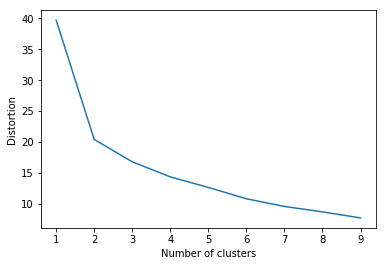

In [50]:
from sklearn.cluster import KMeans
#from sklearn import metrics
#from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

restaurant_grouped_clustering = restaurant_grouped.drop('Neighborhood', 1)
distortion={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(restaurant_grouped_clustering)
    distortion[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(distortion.keys()), list(distortion.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
#plt.show()

In [51]:
# set number of clusters as optimal value from elbow curve
kclusters = 2

restaurant_grouped_clustering = restaurant_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1])

#### Neighborhood Clusters and top restaurants by neighborhood:

In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_data

# merge restaurant_grouped with ny_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,NaN,NaN,NaN,NaN,NaN,NaN
1,Bronx,Co-op City,40.874294,-73.829939,0.0,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,0.0,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,NaN,NaN,NaN,NaN,NaN,NaN
4,Bronx,Riverdale,40.890834,-73.912585,1.0,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Thai Restaurant


In [58]:
nyc_data = ny_merged.dropna()
nyc_data = nyc_data.astype({"Cluster Labels": int})
nyc_data.head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bronx,Co-op City,40.874294,-73.829939,0,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,0,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,1,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Thai Restaurant
5,Bronx,Kingsbridge,40.881687,-73.902818,0,Chinese Restaurant,Afghan Restaurant,Indian Restaurant,Filipino Restaurant,African Restaurant
6,Manhattan,Marble Hill,40.876551,-73.910660,0,Chinese Restaurant,Afghan Restaurant,Japanese Restaurant,Thai Restaurant,Filipino Restaurant
7,Bronx,Woodlawn,40.898273,-73.867315,0,Chinese Restaurant,Indian Restaurant,Vietnamese Restaurant,Filipino Restaurant,African Restaurant
8,Bronx,Norwood,40.877224,-73.879391,0,Chinese Restaurant,Indian Restaurant,Vietnamese Restaurant,Filipino Restaurant,African Restaurant
9,Bronx,Williamsbridge,40.881039,-73.857446,1,Chinese Restaurant,African Restaurant,Indian Restaurant,Vietnamese Restaurant,Filipino Restaurant
10,Bronx,Baychester,40.866858,-73.835798,0,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,African Restaurant,American Restaurant
11,Bronx,Pelham Parkway,40.857413,-73.854756,0,Chinese Restaurant,Thai Restaurant,Vietnamese Restaurant,African Restaurant,American Restaurant


### Examine Clusters  
Examine clusters to identify venue categories that distinguish each cluster. Assign a name to each cluster.

In [65]:
#Cluster 1
nyc_data.loc[nyc_data['Cluster Labels'] == 0, nyc_data.columns[[1] + list(range(5, nyc_data.shape[1]))]]

#Cluster 2
nyc_data.loc[nyc_data['Cluster Labels'] == 1, nyc_data.columns[[1] + list(range(5, nyc_data.shape[1]))]]

nyc_data.loc[nyc_data['Cluster Labels'] == 0, 'Cluster Name'] = "Chinese/Vietnamese/African" 
nyc_data.loc[nyc_data['Cluster Labels'] == 1, 'Cluster Name'] = "Japanese/Thai/Indian" 

#### Visualize Clusters

In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, name in zip(nyc_data['Latitude'], nyc_data['Longitude'], nyc_data['Neighborhood'], nyc_data['Cluster Labels'], nyc_data['Cluster Name']):
    label = folium.Popup(str(poi) + '-' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Conclusion
We are able to see based on the limited restaurant categories we selected, in this case two clusters created the optimal segmentation as displayed above. Neighborhoods in cluster 1 tend to have a higher ratio of Chinese,Vietnamese and African restaurants as compared to other neighborhoods.

For example, it may be better to avoid starting a new chinese restaurant in say, Baychester, since there is already high saturation in that vicinity.

# Limitations 
Below are some of the limitations with this analysis which can be further studied with a more in-depth analysis to better determine restaurant segmentation for general search as well as for a guideline for deciding where to open a new cultural restaurant:
- Taking into account user reviews such as from Yelp may help to get a better feel of what are the locations with the most popular restaurant venue types 
- Expand on the list of restaurant categories to consider for inclusion in initial data retrieval from Foursquare API 
- Add additional features to better form clusters such as demographic/population information for each neighborhood, income, etc.